# Evaluation of your predictive model

## Introduction
Machine-learning models rely on optimizing an objective function, by seeking
its minimum or maximum. It is important to understand that this objective
function is usually decoupled from the evaluation metric that we want to
optimize in practice. The objective function serves as a proxy to the
evaluation metric.
FIXME: add information about a loss function depending of the notebooks
presented before the notebook about metrics.

While other notebooks will give insights regarding algorithms and their
associated objective functions, in this notebook we will focus on the
metrics used to evaluate the performance of a predictive model.

Selecting an evaluation metric will mainly depend on the model chosen to
solve our datascience problem.

## Classification
We can recall that in a classification setting, the target `y` is categorical
rather than continuous. We will use the blood transfusion dataset that will
be fetched from OpenML.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    name="blood-transfusion-service-center",
    as_frame=True, return_X_y=True,
)
# Make columns and classes more human-readable
X.columns = ["Recency", "Frequency", "Monetary", "Time"]
y = y.apply(
    lambda x: "donated" if x == "2" else "not donated"
).astype("category")
y.cat.categories

Index(['not donated', 'donated'], dtype='object')

We can see that the target `y` contains 2 categories corresponding to whether
or not a subject gave blood or not. We will use a logistic regression
classifier to predict this outcome.

First, we split the data into a training and a testing set.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=0, test_size=0.5
)

Once our data are split, we can learn a logistic regression classifier solely
on the training data, keeping the testing data for the evaluation of the
model.

In [3]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

Now, that our classifier is trained, we can provide some information about a
subject and the classifier can predict whether or not the subject will donate
blood.

Let's create a synthetic sample corresponding to the following potential new
donor: he/she donated blood 6 month ago and gave twice blood in the past for
a total of 1000 c.c. He/she gave blood for the first time 20 months ago.

In [4]:
new_donor = [[6, 2, 1000, 20]]
classifier.predict(new_donor)

array(['not donated'], dtype=object)

With these information, our classifier predicted that this synthetic subject
is more likely to not donate blood. However, we have no possibility to ensure
if the prediction is correct or not. That's why, we can now use the testing
set for this purpose. First, we can predict whether or not a subject will
give blood with the help of the trained classifier.

In [5]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

### Accuracy as a baseline
Now that we have these predictions, we could compare them with the true
predictions (sometimes called ground-truth) which we did not use up to now.

In [6]:
y_test == y_pred

258     True
521    False
14     False
31     False
505     True
       ...  
665     True
100    False
422     True
615     True
743     True
Name: Class, Length: 374, dtype: bool

In the comparison above, a `True` value means that the value predicted by our
classifier is identical to the real `prediction` while a `False` means that
our classifier made a mistake. One way to get an overall statistic telling us
how good the performance of our classifier are is to compute the number of
time our classifier was right and divide it by the number of samples in our
set (i.e. taking the mean of correct predictions)

In [7]:
import numpy as np

np.mean(y_test == y_pred)

0.7780748663101604

This measure is also known as the accuracy. Here, our classifier is 78%
accurate at classifying if subject will give blood. `scikit-learn` provides a
function to compute this metric in the module `sklearn.metrics`.

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7780748663101604

Scikit-learn also have a build-in method named `score` which compute by
default the accuracy score.

In [9]:
classifier.score(X_test, y_test)

0.7780748663101604

### Confusion matrix and derived metrics
The comparison that we did above and the accuracy that we deducted did not
take into account which type of error our classifier was doing. The accuracy
is an aggregate of the error. However, we might be interested in a lower
granularity level to know separately the error for the two following case:
- we predicted that a person will give blood but she/he is not;
- we predicted that a person will not give blood but she/he is.

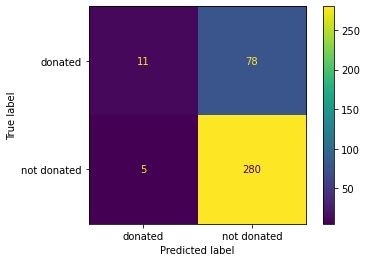

In [10]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test)

The in-diagonal numbers are related to predictions that agree
with the true labels while off-diagonal numbers are related to
misclassification. Besides, we now know the type of true or erroneous
predictions the classifier did:

* the top left corner is called true positive (TP) and correspond to a person
  who gave blood and was predicted as such by the classifier;
* the bottom right corner is called the true negative (TN) and correspond to
  a person who did not gave blood and was predicted as such by the
  classifier;
* the top right corner is called false negative (FN) and correspond to a
  person who gave blood but was predicted as not giving blood;
* the bottom left corner is called false positive (FP) and correspond to a
  person who did not give blood but was predicted as giving blood.

Once we have split these information, we can compute statistics for
highlighting the performance of our classifier in a particular setting. For
instance, one could be interested in the fraction of persons who really gave
blood when the classifier predicted so or the fraction of people predicted as
giving blood among the total population that actually did so.

The former statistic is known as the precision defined as TP / (TP + FP)
while the latter statistic is known as the recall defined as TP / (TP + FN)
We could, similarly than with the accuracy, manually compute these values.
But scikit-learn provides functions to compute these statistics.

In [11]:
from sklearn.metrics import precision_score, recall_score

print(
    f"Precision score: {precision_score(y_test, y_pred, pos_label='donated')}"
    f"\nRecall score: {recall_score(y_test, y_pred, pos_label='donated')}"
)

Precision score: 0.6875
Recall score: 0.12359550561797752


These results are in line with what we could see in the confusion matrix.
In the left column, more than half of the predictions were corrected leading
to a precision above 0.5. However, our classifier mislabeled a lot of persons
who gave blood as "not donated" leading to a very low recall of around 0.1.

The precision and recall can be combined in a single score called the F1
score (which is the harmonic mean of precision and recall)

In [12]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, pos_label='donated')

0.20952380952380953

### The issue of class imbalance
At this stage, we could ask ourself a reasonable question. While the accuracy
did not look bad (i.e. 77%), the F1 score is relatively low (i.e. 21%).

As we mentioned, precision and recall only focus on the positive label while
the accuracy is taking both aspects into account. In addition,
we omit to look at the ratio class
occurrence. We could check this ratio in the training set.

In [13]:
from collections import Counter

class_counts = pd.Series(Counter(y_train))
class_counts /= class_counts.sum()
class_counts

not donated    0.762032
donated        0.237968
dtype: float64

So we can observed that the positive class `'donated'` is only 24% of the
total number of instances. The good accuracy of our classifier is then linked
to its capability of predicting correctly the negative class `'not donated'`
which could be relevant or not depending of the application. We can
illustrate the issue using a dummy classifier as a baseline.

In [14]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(
    strategy="constant", constant="not donated"
)
dummy_classifier.fit(X_train, y_train).score(X_test, y_test)

0.7620320855614974

This dummy classifier will always predict the negative class `'not donated'`.
We obtain an accuracy score of 76%. Therefore, it means that this classifier,
without learning anything from the data `X` is capable of predicting as
accurately than our logistic regression. 76% represents the baseline that
any classifier should overperform to not be a random classifier.

The problem illustrated above is also known as the class imbalance problem
where the accuracy should not be used. In this case, one should either use
the precision, recall, or F1 score as presented above or the balanced
accuracy score instead of the accuracy.

In [15]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5530258229844274

The balanced accuracy is equivalent to the accuracy in the context of
balanced classes. It is defined as the average recall obtained on each class.

### Evaluation with different probability threshold

All statistics that we presented up to now rely on `classifier.predict` which
provide the most likely label. However, we don't use the probability
associated with this prediction or in other words how sure are the classifier
confident about this prediction. By default, the prediction of a classifier
correspons to a thresholding at a 0.5 probability, in a binary classification
problem. We can quickly check this relationship with the classifier that
we trained.

In [16]:
y_proba = pd.DataFrame(
    classifier.predict_proba(X_test),
    columns=classifier.classes_
)
y_proba[:5]

,donated,not donated
0,0.271820,0.728180
1,0.451764,0.548236
2,0.445211,0.554789
3,0.441577,0.558423
4,0.870583,0.129417


In [17]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

In [18]:
# Since probabilities sum to 1 we can get the class with the highest
# probability without using the threshold 0.5
equivalence_pred_proba = (
    y_proba.idxmax(axis=1).to_numpy() == y_pred
)
np.all(equivalence_pred_proba)

True

The default decision threshold (0.5) might not be the best threshold leading
to optimal performance of our classifier. In this case, one can vary the
decision threshold and therefore the underlying prediction and compute the
same statistic than presented earlier. Usually, two metrics are computed and
reported as a curve. Each metric is belonging to a graph axis and a point on
the graph corresponds to a specific decision threshold. Let's start by
computing the precision-recall curve.

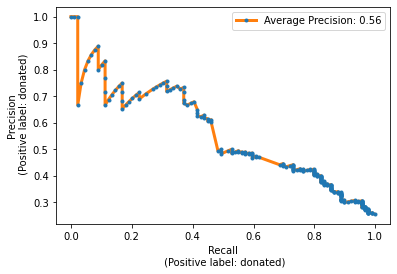

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_pred = classifier.predict_proba(X_test)
pos_label = "donated"
precision, recall, threshold = precision_recall_curve(
    y_test, y_pred[:, 0], pos_label=pos_label,
)
average_precision = average_precision_score(
    y_test, y_pred[:, 0], pos_label=pos_label,
)
plt.plot(
    recall, precision,
    color="tab:orange", linewidth=3,
    marker=".", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
    label=f"Average Precision: {average_precision:.2f}",
)
plt.xlabel(f"Recall\n (Positive label: {pos_label})")
plt.ylabel(f"Precision\n (Positive label: {pos_label})")
plt.legend()

# # FIXME: to be used when solved in scikit-learn
# from sklearn.metrics import plot_precision_recall_curve

# disp = plot_precision_recall_curve(
#     classifier, X_test, y_test, pos_label='donated',
# )

On this curve, each blue dot correspond to a certain level of probability
which we used as a decision threshold. We can see that by varying this
decision threshold, we get different compromise precision vs. recall.

A perfect classifier is expected to have a precision at 1 even when varying
the recall. A metric characterizing the curve is linked to the area under the
curve (AUC), named averaged precision. With a ideal classifier, the
average precision will be 1.

While the precision and recall metric focuses on the positive class, one
might be interested into the compromise between performance to discriminate
positive and negative classes. The statistics used in this case are the
sensitivity and specificity. The sensitivity is just another denomination for
recall. However, the specificity measures the proportion of well classified
samples from the negative class defined as TN / (TN + FP). Similarly to the
precision-recall curve, sensitivity and specificity are reported with a curve
called the receiver operating characteristic (ROC) curve. We will show such
curve:

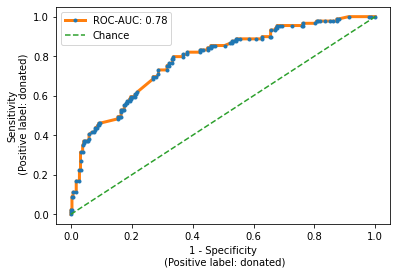

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred[:, 0], pos_label=pos_label)
# FIXME: roc_auc_score has a bug and we need to give the inverse probability
# vector. Should be changed when the following is merged and released:
# https://github.com/scikit-learn/scikit-learn/pull/17594
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
plt.plot(
    fpr, tpr,
    color="tab:orange", linewidth=3,
    marker=".", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
    label=f"ROC-AUC: {roc_auc:.2f}"
)
plt.plot([0, 1], [0, 1], "--", color="tab:green", label="Chance")
plt.xlabel(f"1 - Specificity\n (Positive label: {pos_label})")
plt.ylabel(f"Sensitivity\n (Positive label: {pos_label})")
plt.legend()

# # FIXME: to be used when solved in scikit-learn
# from sklearn.metrics import plot_roc_curve

# plot_roc_curve(classifier, X_test, y_test, pos_label='donated')

This curve is built with the same principle than with the precision-recall
curve: we vary the probability threshold to compute "hard" prediction and
compute the metrics. As with the precision-recall curve as well, we can
compute the area under the ROC (ROC-AUC) to characterize the performance of
our classifier. However, this is important to observer that the lower bound
of the ROC-AUC is 0.5. Indeed, we represented the performance of a dummy
classifier (i.e. green dashed line) to show that the worse performance
obtained will always be above this line.

### Link between confusion matrix, precision-recall curve and ROC curve

TODO: ipywidgets to play with interactive curve

In [21]:
def plot_pr_curve(classifier, X_test, y_test, pos_label,
                  probability_threshold, ax):
    y_pred = classifier.predict_proba(X_test)
    precision, recall, threshold = precision_recall_curve(
        y_test, y_pred[:, 0], pos_label=pos_label,
    )
    average_precision = average_precision_score(
        y_test, y_pred[:, 0], pos_label=pos_label,
    )
    ax.plot(
        recall, precision,
        color="tab:orange", linewidth=3,
        label=f"Average Precision: {average_precision:.2f}",
    )
    threshold_idx = np.searchsorted(
        threshold, probability_threshold,
    )
    ax.plot(
        recall[threshold_idx], precision[threshold_idx],
        color="tab:blue", marker=".", markersize=10,
    )
    ax.plot(
        [recall[threshold_idx], recall[threshold_idx]],
        [0, precision[threshold_idx]],
        '--', color="tab:blue",
    )
    ax.plot(
        [0, recall[threshold_idx]],
        [precision[threshold_idx], precision[threshold_idx]],
        '--', color="tab:blue",
    )
    ax.set_xlabel(f"Recall")
    ax.set_ylabel(f"Precision")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    return ax

In [22]:
def plot_roc_curve(classifier, X_test, y_test, pos_label,
                   probability_threshold, ax):
    y_pred = classifier.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_pred[:, 0], pos_label=pos_label)
    roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    ax.plot(
        fpr, tpr,
        color="tab:orange", linewidth=3,
        label=f"ROC-AUC: {roc_auc:.2f}"
    )
    ax.plot([0, 1], [0, 1], "--", color="tab:green", label="Chance")
    threshold_idx = np.searchsorted(
        threshold[::-1], probability_threshold,
    )
    threshold_idx = len(threshold) - threshold_idx - 1
    ax.plot(
        fpr[threshold_idx], tpr[threshold_idx],
        color="tab:blue", marker=".", markersize=10,
    )
    ax.plot(
        [fpr[threshold_idx], fpr[threshold_idx]],
        [0, tpr[threshold_idx]],
        '--', color="tab:blue",
    )
    ax.plot(
        [0, fpr[threshold_idx]],
        [tpr[threshold_idx], tpr[threshold_idx]],
        '--', color="tab:blue",
    )
    ax.set_xlabel(f"1 - Specificity")
    ax.set_ylabel(f"Sensitivity")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()
    return ax

In [23]:
def plot_confusion_matrix_with_threshold(classifier, X_test, y_test, pos_label,
                                         probability_threshold, ax):
    from itertools import product
    from sklearn.metrics import confusion_matrix

    class_idx = np.where(classifier.classes_ == pos_label)[0][0]
    n_classes = len(classifier.classes_)

    y_pred = classifier.predict_proba(X_test)
    y_pred = (y_pred[:, class_idx] > probability_threshold).astype(int)

    cm = confusion_matrix(
        (y_test == pos_label).astype(int), y_pred,
    )
    im_ = ax.imshow(cm, interpolation='nearest')

    text_ = None
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    text_ = np.empty_like(cm, dtype=object)

    # print text with appropriate color depending on background
    thresh = (cm.max() + cm.min()) / 2.0

    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min

        text_cm = format(cm[i, j], '.2g')
        if cm.dtype.kind != 'f':
            text_d = format(cm[i, j], 'd')
            if len(text_d) < len(text_cm):
                text_cm = text_d

        text_[i, j] = ax.text(
            j, i, text_cm, ha="center", va="center", color=color
        )

    ax.set(
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=classifier.classes_[[int(not bool(class_idx)), class_idx]],
        yticklabels=classifier.classes_[[int(not bool(class_idx)), class_idx]],
        ylabel="True label",
        xlabel="Predicted label"
    )

In [24]:
def plot_pr_roc(threshold):
    # FIXME: we could optimize the plotting by only updating the the
    fig, axs = plt.subplots(ncols=3, figsize=(21, 6))
    plot_pr_curve(
        classifier, X_test, y_test, pos_label="donated",
        probability_threshold=threshold, ax=axs[0],
    )
    plot_roc_curve(
        classifier, X_test, y_test, pos_label="donated",
        probability_threshold=threshold, ax=axs[1]
    )
    plot_confusion_matrix_with_threshold(
        classifier, X_test, y_test, pos_label="donated",
        probability_threshold=threshold, ax=axs[2]
    )
    fig.suptitle("Overall performance with positive class 'donated'")

In [25]:
def plot_pr_roc_interactive():
    from ipywidgets import interactive, FloatSlider
    slider = FloatSlider(min=0, max=1, step=0.01, value=0.5)
    return interactive(plot_pr_roc, threshold=slider)

In [26]:
plot_pr_roc_interactive()

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

## Regression
Unlike in the classification problem, the target `y` is a continuous
variable in regression problem. Therefore, the classification metrics can be
used to evaluate the performance of a model. Instead, there exists a set of
metric dedicated to regression.

In [27]:
data = pd.read_csv(
    ("https://raw.githubusercontent.com/christophM/interpretable-ml-book/"
     "master/data/bike.csv"),
)
# rename the columns with human-readable names
data = data.rename(columns={
    "yr": "year", "mnth": "month", "temp": "temperature", "hum": "humidity",
    "cnt": "count", "days_since_2011": "days since 2011"
})
# convert the categorical columns with a proper category data type
for col in data.columns:
    if data[col].dtype.kind == "O":
        data[col] = data[col].astype("category")

# separate the target from the original data
X = data.drop(columns=["count"])
y = data["count"]

In [28]:
X.head()

,season,year,month,holiday,weekday,workingday,weathersit,temperature,humidity,windspeed,days since 2011
0,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,0
1,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,1
2,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,2
3,SPRING,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,3
4,SPRING,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,4


Text(0.5, 1.0, 'Target distribution')

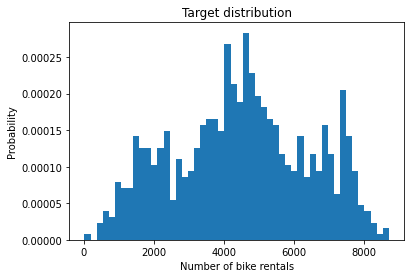

In [29]:
plt.hist(y, bins=50, density=True)
plt.xlabel("Number of bike rentals")
plt.ylabel("Probability")
plt.title("Target distribution")

Our problem can be formulated as follow: we would like to infer the number of
bike rentals from data related to the current day. The number of bike rentals
is a number that can vary in the interval [0, infinity) (if the number of
bike available is infinite). As in the previous section, we will train a
model and we will evaluate its performance by introducing the different
regression metrics.

First, we split the data into a training and a testing set.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=0
)

### Baseline model
We will use a random forest as a model. However, we first need to check the
type of data that we are dealing with:

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 452 to 684
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   season           548 non-null    category
 1   year             548 non-null    int64   
 2   month            548 non-null    category
 3   holiday          548 non-null    category
 4   weekday          548 non-null    category
 5   workingday       548 non-null    category
 6   weathersit       548 non-null    category
 7   temperature      548 non-null    float64 
 8   humidity         548 non-null    float64 
 9   windspeed        548 non-null    float64 
 10  days since 2011  548 non-null    int64   
dtypes: category(6), float64(3), int64(2)
memory usage: 30.1 KB


While some features are numeric, some have been tagged as `category`. These
features need to be encoded in a proper way such that our random forest can
deal with them. The simplest solution is to use an `OrdinalEncoder`.
Regarding, the numerical features, we don't need to do anything. Thus, we
will create a preprocessing steps to take care about this encoding.

In [32]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder

categorical_selector = selector(dtype_include="category")
preprocessor = make_column_transformer(
    (OrdinalEncoder(), categorical_selector),
    remainder="passthrough",
)

X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=(
        categorical_selector(X_train) +
        [col for col in X_train.columns
         if col not in categorical_selector(X_train)]
    )
)
X_train_preprocessed.head()

,season,month,holiday,weekday,workingday,weathersit,year,temperature,humidity,windspeed,days since 2011
0,2.0,7.0,1.0,6.0,1.0,0.0,2012.0,14.755849,48.1250,19.541957,452.0
1,3.0,2.0,1.0,3.0,0.0,0.0,2011.0,7.549151,77.5833,5.625206,337.0
2,2.0,8.0,1.0,4.0,1.0,0.0,2012.0,22.785000,71.6667,11.584032,509.0
3,1.0,7.0,1.0,2.0,0.0,0.0,2011.0,14.207500,37.9167,24.667189,77.0
4,2.0,7.0,1.0,5.0,1.0,0.0,2012.0,7.196651,29.0000,12.541864,451.0


Just to have some insights about the preprocessing, we manually preprocessed
the training data and we can observe that the original strings were encoded
with numbers. We can now create our model.

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

regressor = make_pipeline(preprocessor, RandomForestRegressor())
regressor.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f050b4370d0>)])),
                ('randomforestregressor', RandomForestRegressor())])

As for classifiers, regressors have a `score` method which will compute the
:math:`R^2` score (also known as the coefficient of determination) by
default:

In [34]:
regressor.score(X_test, y_test)

0.8954501389537288

The :math:`R^2` score represents the proportion of variance of the target
explained by the independent variables in the model. The best score possible
is 1 but there is no lower bound. However, a model which would predict the
expected value of the target would get a score of 0.

In [35]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train).score(X_test, y_test)

-8.48919596840858e-08

The :math:`R^2` score gives insights regarding the goodness of fit of the
model. However, this score cannot be compared from one dataset to another and
the value obtained does not have a meaningful interpretation regarding the
original unit of the target. If we want to get such interpretable score, we
will be interested into the median or mean absolute error.

In [36]:
from sklearn.metrics import mean_absolute_error

y_pred = regressor.predict(X_test)
print(
    f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.0f}"
)

Mean absolute error: 509


By computing the mean absolute error, we can interpret that our model is
predicting in average 507 bike rentals away from the truth. The mean can be
impacted by large error while for some application, we would like to discard
them and we can in this case opt for the median absolute error.

In [37]:
from sklearn.metrics import median_absolute_error

print(
    f"Median absolute error: {median_absolute_error(y_test, y_pred):.0f}"
)

Median absolute error: 375


In this case, our model make an error of 405 bikes.
FIXME: **not sure how to introduce the `mean_squared_error`.**

In addition of metrics, we can visually represent the results by plotting
the predicted values versus the true values.

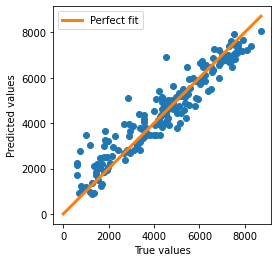

In [38]:
def plot_predicted_vs_actual(y_true, y_pred, title=None):
    plt.scatter(y_true, y_pred)

    max_value = np.max([y_true.max(), y_pred.max()])
    plt.plot(
        [0, max_value],
        [0, max_value],
        color="tab:orange",
        linewidth=3,
        label="Perfect fit",
    )

    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.axis("square")
    plt.legend()
    if title is not None:
        plt.title(title)


plot_predicted_vs_actual(y_test, y_pred)

On this plot, the perfect prediction will lay on the diagonal line. This plot
allows to detect if the model have a specific regime where our model does not
work as expected or has some kinda of bias.

Let's take an example using the house prices in Ames.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

X, y = fetch_openml(name="house_prices", as_frame=True, return_X_y=True)
X = X.select_dtypes(np.number).drop(
    columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

We will fit a ridge regressor on the data and plot the prediction versus the
actual values.

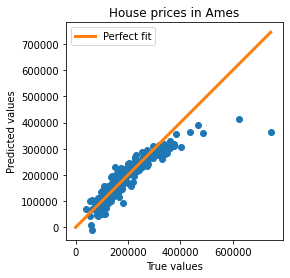

In [40]:
model = make_pipeline(StandardScaler(), RidgeCV())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plot_predicted_vs_actual(y_test, y_pred, title="House prices in Ames")

On this plot, we see that for the large "True values", our model tend to
under-estimate the price of the house. Typically, this issue arises when
the target to predict does not follow a normal distribution and the model
could benefit of an intermediate target transformation.

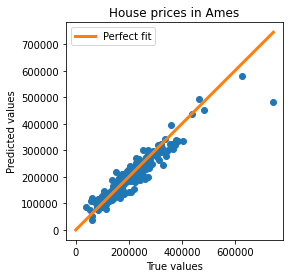

In [41]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

model_transformed_target = TransformedTargetRegressor(
    regressor=model,
    transformer=QuantileTransformer(
        n_quantiles=900, output_distribution="normal"
    ),
)
model_transformed_target.fit(X_train, y_train)
y_pred = model_transformed_target.predict(X_test)

plot_predicted_vs_actual(y_test, y_pred, title="House prices in Ames")

Thus, once we transformed the target, we see that we corrected some of the
high values.

## Summary
In this notebook, we presented the metrics and plots useful to evaluate and
get insights about models. We both focus on regression and classification
problems.